# Supervised Learning

## Setup and Imports

In [144]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report



## Loading Processed Data and Feature Engineering

The dataset that we are taking in here has already tokenized and lemmetized the text and got rid of every extra word that will not help with identifying fake reviews. It has also cleaned up the dataset itself so that it is ready for feature engineering.

In [ ]:
data = pd.read_csv("../data/processed_dataFinale.csv")

data['processed_text'] = data['processed_text'].apply(json.loads)

In [146]:
data.head()

,category,rating,label,text,processed_text
0,Home_and_Kitchen,5,CG,"Love this! Well made, sturdy, and very comfor...","[love, well, make, sturdy, comfortable, love, ..."
1,Home_and_Kitchen,5,CG,"love it, a great upgrade from the original. I...","[love, great, upgrade, original, mine, couple,..."
2,Home_and_Kitchen,5,CG,This pillow saved my back. I love the look and...,"[pillow, save, back, love, look, feel, pillow]"
3,Home_and_Kitchen,1,CG,"Missing information on how to use it, but it i...","[miss, information, use, great, product, price]"
4,Home_and_Kitchen,5,CG,Very nice set. Good quality. We have had the s...,"[nice, set, good, quality, set, two, month]"


In [147]:
# Convert 'processed_text' from list to string
data['processed_text_str'] = data['processed_text'].apply(' '.join)


In [148]:
data.head()

,category,rating,label,text,processed_text,processed_text_str
0,Home_and_Kitchen,5,CG,"Love this! Well made, sturdy, and very comfor...","[love, well, make, sturdy, comfortable, love, ...",love well make sturdy comfortable love pretty
1,Home_and_Kitchen,5,CG,"love it, a great upgrade from the original. I...","[love, great, upgrade, original, mine, couple,...",love great upgrade original mine couple year
2,Home_and_Kitchen,5,CG,This pillow saved my back. I love the look and...,"[pillow, save, back, love, look, feel, pillow]",pillow save back love look feel pillow
3,Home_and_Kitchen,1,CG,"Missing information on how to use it, but it i...","[miss, information, use, great, product, price]",miss information use great product price
4,Home_and_Kitchen,5,CG,Very nice set. Good quality. We have had the s...,"[nice, set, good, quality, set, two, month]",nice set good quality set two month


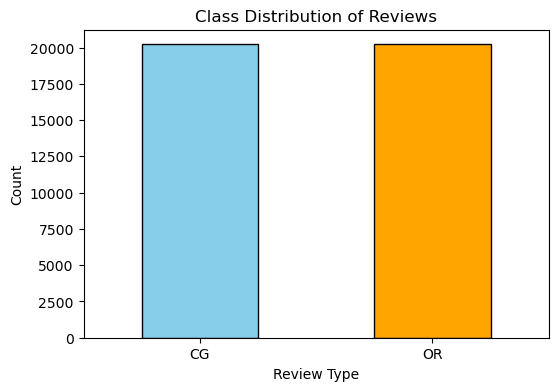

In [165]:
# Class Distribution
plt.figure(figsize=(6, 4))
data['label'].value_counts().plot(kind='bar', color=['skyblue', 'orange'], edgecolor='black')
plt.title("Class Distribution of Reviews")
plt.xlabel("Review Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


## Feature Engineering

The code below uses TF-IDF Vectorization to transform the processed_text_str into a numerical format that will be suitable for machine learning models. TF-IDF (Term Frequency-Inverse Document Frequency) quantifies the importance of words in a document relative to a collection of documents. Here each row represents a document, and each column represents a word from the vocabulary, and each value is the TF-IDS score of that given document. 

In [149]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')  # Limit to top 1000 features
tfidf_features = tfidf.fit_transform(data['processed_text_str'])

# Convert TF-IDF features to a DataFrame
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf.get_feature_names_out())


The code below calculates the text length (the number of characters in each review) and the unique word ratio (the proportion of unique words to total words in each review). Then these new features are combined with the previously generated TF-IDF features. Next we use the category column and convert each unique category into a seperate binary feature. These one-hot encoded feature are then added to the feature set. 

In [150]:
# Text length
data['text_length'] = data['text'].apply(len)

# Unique word ratio
data['unique_word_ratio'] = data['processed_text'].apply(lambda tokens: len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0)

# Combine all features
features = pd.concat([tfidf_df, data[['text_length', 'unique_word_ratio', 'rating']]], axis=1)

# One-hot encoding for category
categories = pd.get_dummies(data['category'], prefix='category')
features = pd.concat([features, categories], axis=1)



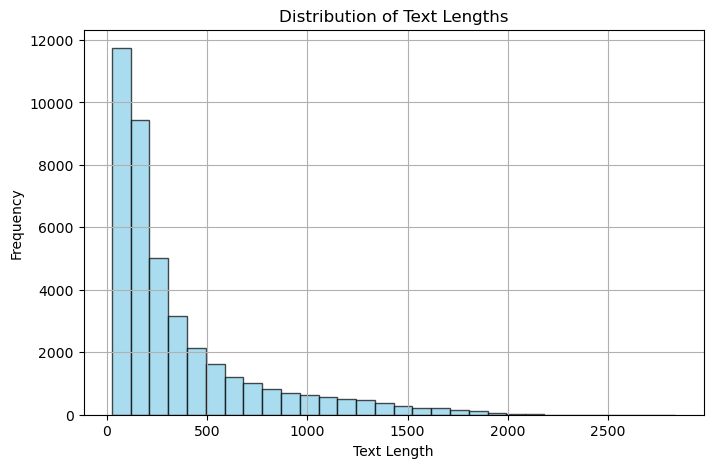

In [166]:
# Text Length Distribution
plt.figure(figsize=(8, 5))
plt.hist(data['text_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.grid()
plt.show()


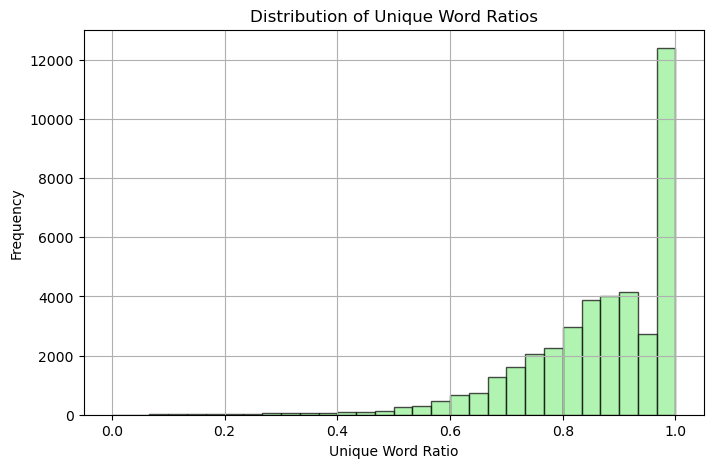

In [167]:
# Unique Word Ratio Distribution
plt.figure(figsize=(8, 5))
plt.hist(data['unique_word_ratio'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title("Distribution of Unique Word Ratios")
plt.xlabel("Unique Word Ratio")
plt.ylabel("Frequency")
plt.grid()
plt.show()


## Supervised Machine Learning

Standardization ensures that all features have a mean of 0 and std. dev. of 1. This is needed for many machine learning algorithms, like Logistic Regression and PCA, which wil lbe used later on in the code. 

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features) 

This converts the categorical labels CG (Computer Generated) and OR (Original) into numerical values. So CG --> 0 and OR --> 1

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])

In [153]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, data['label_encoded'], test_size=0.2, random_state=42, stratify=data['label_encoded']
)

## Logistic Regression

Here we used Logistic Regression for this classification task as it is fairly simple, efficient and interpretable. It works pretty well with high-dimensional data, like our dataset, and provides probabilistic outputs that are useful for understanding predections. 

Logistic Regression Performance
              precision    recall  f1-score   support

          CG       0.83      0.83      0.83      4044
          OR       0.83      0.84      0.83      4043

    accuracy                           0.83      8087
   macro avg       0.83      0.83      0.83      8087
weighted avg       0.83      0.83      0.83      8087

Logistic Regression R² (Training): 0.85
Logistic Regression R² (Test): 0.83


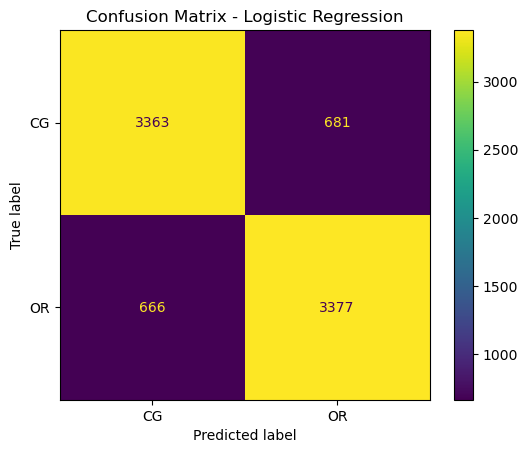

In [162]:
# Train Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Predict and evaluate Logistic Regression
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Performance")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

# R² Scores for Logistic Regression
print(f"Logistic Regression R² (Training): {lr.score(X_train, y_train):.2f}")
print(f"Logistic Regression R² (Test): {lr.score(X_test, y_test):.2f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

#### Interpretation of the Results from Logistic Regression

We can see that the model achives an 83% accuracy and F1-score for both CG and OR reviews, this indicates a balanced and effective classification. 

Precision (83%) and Recall (83%-84%) are consistent across both classes, showing that the model is equally good at identifying true positives while minimizing false positives and negatives.

The R² scores for training (85%) and test (83%) indicate good generalization without overfitting.

- True Positives (CG, CG) = 3363
- True Negatives (OR, OR) = 3377
- False Positives (OR, CG) = 666
- False Negatives (CG, OR) = 681

Overall, Logistic Regression performs well as a baseline model, providing interpretable and reliable results.

## Random Forest

Random Forest is a powerful and flexible machine learning algorithm that is well-suited for this classification task. This machine learning method may be a good choice as it handles high-dimensional data, gives insights into feature importance and give good generalization.

Random Forest Performance
              precision    recall  f1-score   support

          CG       0.83      0.86      0.85      4044
          OR       0.85      0.83      0.84      4043

    accuracy                           0.84      8087
   macro avg       0.84      0.84      0.84      8087
weighted avg       0.84      0.84      0.84      8087

Random Forest R² (Training): 1.00
Random Forest R² (Test): 0.84


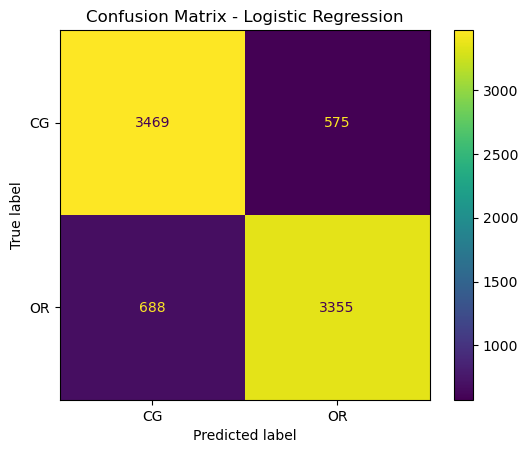

In [163]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate Random Forest
y_pred_rf = rf.predict(X_test)
print("Random Forest Performance")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

# R² Scores for Random Forest
print(f"Random Forest R² (Training): {rf.score(X_train, y_train):.2f}")
print(f"Random Forest R² (Test): {rf.score(X_test, y_test):.2f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.show()

#### Interpretation of the Results from Random Forest

We can see that the Random Forest model achieves an 84% accuracy and F1-score for both CG and OR reviews, indicating a strong and balanced classification performance.

Precision (83%-85%) and Recall (83%-86%) are consistent across both classes, showing the model performs slightly better at identifying true positives for CG reviews while maintaining strong performance for OR reviews.

The R² scores for training (100%) and test (84%) indicate good generalization but suggest slight overfitting, which is expected with Random Forest due to its tendency to perfectly fit training data.

- True Positives (CG, CG) = 3469
- True Negatives (OR, OR) = 3355
- False Positives (OR, CG) = 688
- False Negatives (CG, OR) = 575

Overall, the Random Forest model provides reliable and interpretable results, with robust generalization to unseen data and balanced performance across both classes. Further optimization could focus on reducing overfitting and minimizing misclassifications.

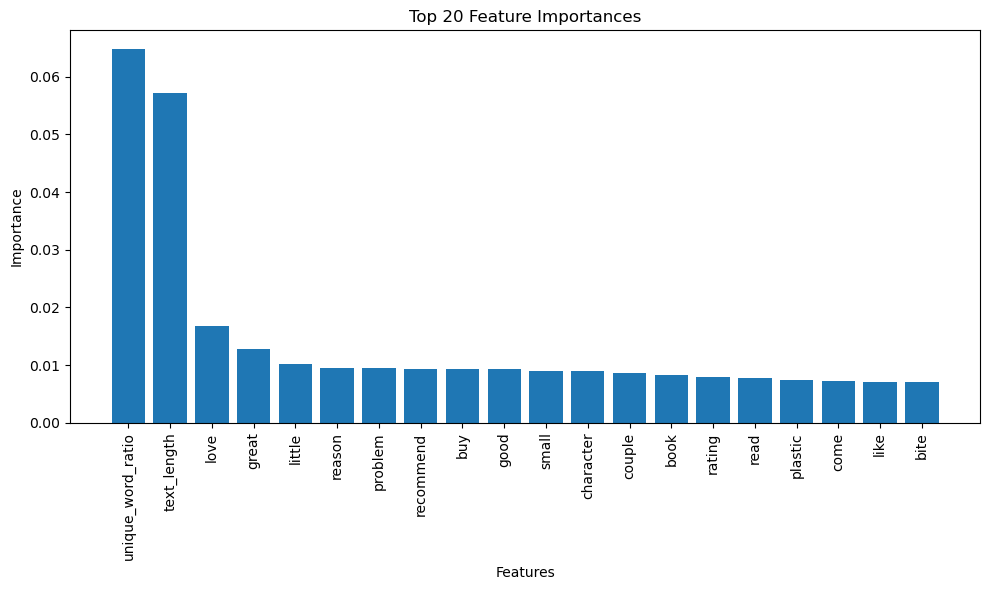

In [156]:
# Map feature importances back to original feature names
importances = rf.feature_importances_  # Get feature importances from the trained Random Forest model
feature_names = features.columns  # Original feature names before scaling
sorted_indices = np.argsort(importances)[::-1]  # Sort indices by importance (descending order)

# Plot only the top 20 features
top_n = 20
plt.figure(figsize=(10, 6))
plt.title(f"Top {top_n} Feature Importances")
plt.bar(range(top_n), importances[sorted_indices][:top_n], align="center")
plt.xticks(range(top_n), feature_names[sorted_indices][:top_n], rotation=90)
plt.ylabel("Importance")
plt.xlabel("Features")
plt.tight_layout()
plt.show()



The bar chart displays the top 20 most important features used by the Random Forest model for classification. The Unique Word Ratio is the most significant feature, followed by Text Length, indicating that structural aspects of the reviews strongly influence the model's predictions. Among the TF-IDF features, words like "love," "great," and "reason" also contribute to distinguishing between CG (computer-generated) and OR (original) reviews, though with lower individual importance. This combination of text-derived metrics and specific keywords highlights the model's ability to leverage both linguistic and structural patterns for effective classification.

## PCA for Dimensionality Reduction

### Apply PCA for Dimensionality Reduction

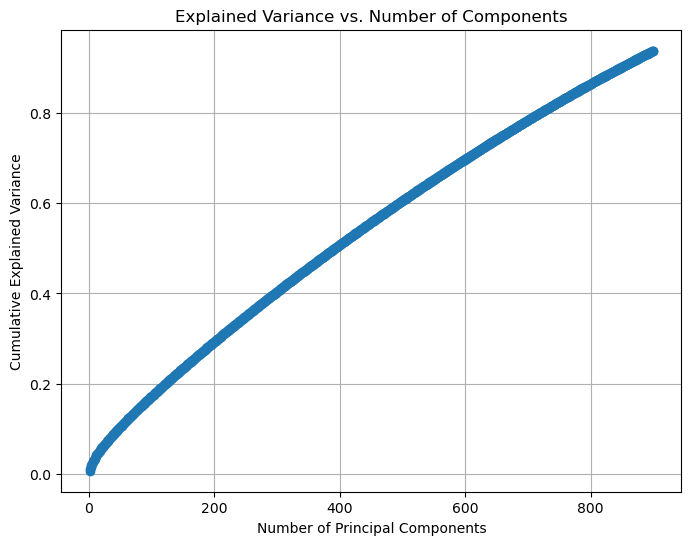

Maximum Cumulative Explained Variance: 0.94


In [158]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Apply PCA
n_components = 900
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# Print the maximum cumulative variance
print(f"Maximum Cumulative Explained Variance: {cumulative_variance[-1]:.2f}")


In [159]:
# Find number of components for 95% variance
explained_variance_threshold = 0.95
if cumulative_variance[-1] < explained_variance_threshold:
    print(f"95% variance cannot be achieved even with all components. Max variance: {cumulative_variance[-1]:.2f}")
else:
    optimal_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1
    print(f"Number of components needed to retain 95% variance: {optimal_components}")


95% variance cannot be achieved even with all components. Max variance: 0.94


If we reduce the dimensionality to 900 n_components then we get that the Maximum Cumulative Explained Variance: 0.94. This indicates that our dataset's features are not strongly correlated, and no small number of components can explain most of the variance. We could see from the Random Forest feature importance that the most important feature was the "Unique word ratio" but it was only roughly 0.06 which indicates that it will be quite hard to reduce the dimensionality of the dataset features. 

Next we tried to investigate the usage of Gradient Boosting as it can handle high dimensionality quite well.

## Gradient Boosting

Gradient Boosting, and specifically LightGBM, is a powerful algorithm for this classification task due to its ability to be efficient with large datasets, handle high-dimensional datasets and robustness and generalization. 

[LightGBM] [Info] Number of positive: 16173, number of negative: 16172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108866
[LightGBM] [Info] Number of data points in the train set: 32345, number of used features: 1013
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500015 -> initscore=0.000062
[LightGBM] [Info] Start training from score 0.000062
LightGBM Performance
              precision    recall  f1-score   support

          CG       0.87      0.86      0.86      4044
          OR       0.86      0.87      0.86      4043

    accuracy                           0.86      8087
   macro avg       0.86      0.86      0.86      8087
weighted avg       0.86      0.86      0.86      8087

LightGBM R² (Training): 0.91
LightGBM R² (Test): 0.86


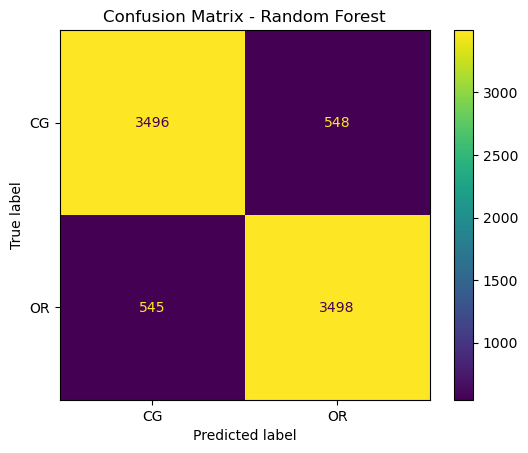

In [ ]:
from lightgbm import LGBMClassifier

# Train LightGBM
lgbm = LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=-1, random_state=42)
lgbm.fit(X_train, y_train)

# Predict and evaluate LightGBM
y_pred_lgbm = lgbm.predict(X_test)
print("LightGBM Performance")
print(classification_report(y_test, y_pred_lgbm, target_names=label_encoder.classes_))

# R² Scores for LightGBM
print(f"LightGBM R² (Training): {lgbm.score(X_train, y_train):.2f}")
print(f"LightGBM R² (Test): {lgbm.score(X_test, y_test):.2f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(lgbm, X_test, y_test, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()


#### Interpretation of the Results from Gradient Boosting

We can see that the LightGBM model achieves an 86% accuracy and F1-score for both CG and OR reviews, indicating strong and balanced classification performance.

Precision (86%-87%) and Recall (86%-87%) are consistent across both classes, showing the model performs equally well at identifying true positives for both CG and OR reviews.

The R² scores for training (91%) and test (86%) indicate good generalization with minimal overfitting, as the difference between training and test performance is small.

- True Positives (CG, CG) = 3496
- True Negatives (OR, OR) = 3498
- False Positives (OR, CG) = 545
- False Negatives (CG, OR) = 548

Overall, the LightGBM model provides reliable and balanced results, with strong generalization to unseen data. Its performance is slightly better than the Random Forest model, making it an excellent choice for this classification task. Further optimization through hyperparameter tuning could further improve its performance and reduce misclassifications.

## Overall Model Comparison

In [171]:
# Extracted metrics
model_comparison = {
    "Metric": ["Accuracy", "F1-Score", "R² (Train)", "R² (Test)", 
               "True Positives (CG)", "True Negatives (OR)", 
               "False Positives (OR)", "False Negatives (CG)"],
    "Logistic Regression": [0.83, 0.83, 0.85, 0.83, 3363, 3377, 666, 681],
    "Random Forest": [0.84, 0.84, 1.00, 0.84, 3469, 3355, 688, 575],
    "LightGBM": [0.86, 0.86, 0.91, 0.86, 3496, 3498, 545, 548]
}

# Create a DataFrame
comparison_df = pd.DataFrame(model_comparison)

# Display the DataFrame
comparison_df.set_index("Metric", inplace=True)
comparison_df


,Logistic Regression,Random Forest,LightGBM
Metric,,,
Accuracy,0.83,0.84,0.86
F1-Score,0.83,0.84,0.86
R² (Train),0.85,1.00,0.91
R² (Test),0.83,0.84,0.86
True Positives (CG),3363.00,3469.00,3496.00
True Negatives (OR),3377.00,3355.00,3498.00
False Positives (OR),666.00,688.00,545.00
False Negatives (CG),681.00,575.00,548.00


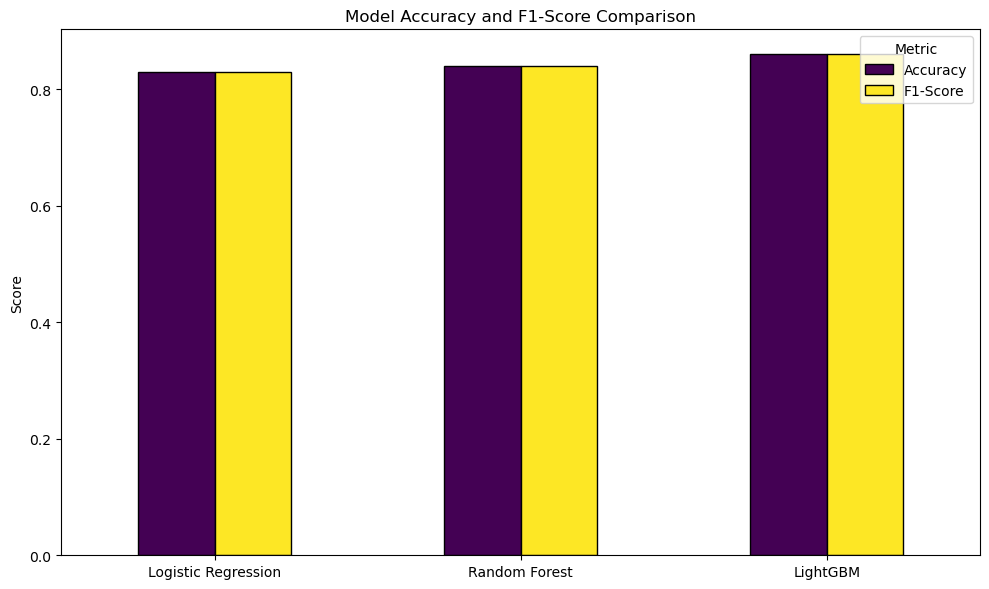

In [172]:
# Accuracy and F1-Score Bar Plot
comparison_df.loc[["Accuracy", "F1-Score"]].T.plot(kind="bar", figsize=(10, 6), colormap="viridis", edgecolor="black")
plt.title("Model Accuracy and F1-Score Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


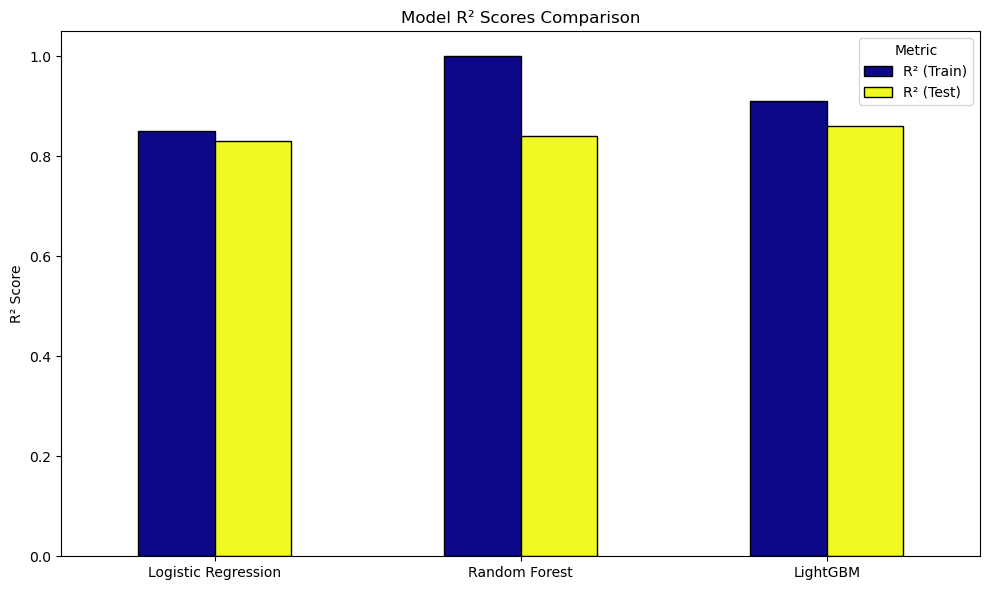

In [173]:
# R² Scores Bar Plot
comparison_df.loc[["R² (Train)", "R² (Test)"]].T.plot(kind="bar", figsize=(10, 6), colormap="plasma", edgecolor="black")
plt.title("Model R² Scores Comparison")
plt.ylabel("R² Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


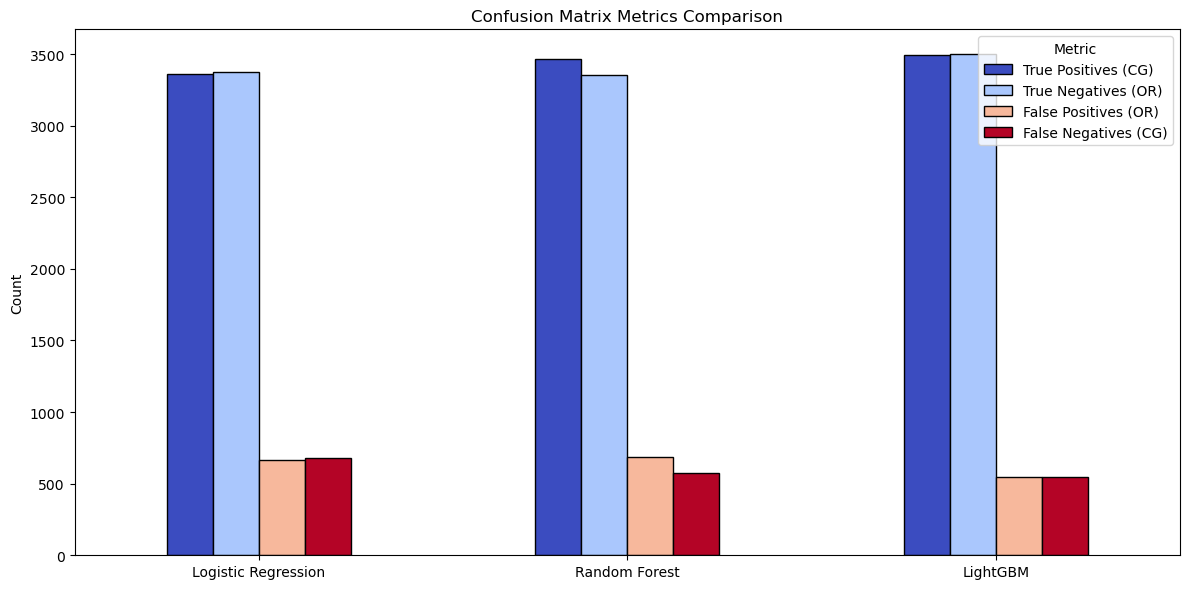

In [174]:
# Confusion Matrix Metrics Bar Plot
comparison_df.loc[["True Positives (CG)", "True Negatives (OR)", 
                   "False Positives (OR)", "False Negatives (CG)"]].T.plot(kind="bar", figsize=(12, 6), colormap="coolwarm", edgecolor="black")
plt.title("Confusion Matrix Metrics Comparison")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Final Conclusions

Based on the evaluation metrics and the visualizations from the Logistic Regression, Random Forest, and LightGBM models, we can draw the following conclusions:

#### Gradiant Boosting (LightGBM) is the Best Choice

- It has the highest accuracy and F1-score (86%):
    - LightGBM consistently achieves the best results across accuracy and F1-score, indicating its ability to balance precision and recall effectively.
- Balanced Performance:
    - With the fewest false positives (545) and false negatives (548) compared to other models, LightGBM demonstrates better classification reliability for both CG and OR reviews.
- Minimal Overfitting:
    - LightGBM has R² scores of 91% (training) and 86% (test), indicating strong generalization to unseen data with minimal overfitting.
